# Rayleigh-Taylor Instability


We will simulate the incompressible Rayleigh-Taylor instability.  We non-dimensionalize the problem by taking the box height to be one, $g = 1$, the maximum concentration at $t=0$ $C_{0} = 1$.  Then the Reynolds number is given by

$$ \mathrm{Re} = \frac{U H}{\nu} = \frac{(g\beta)^{\frac{1}{2}}H^{\frac{3}{2}}}{\nu} = \frac{\beta^{\frac{1}{2}}}{\nu}.$$ where $U = \sqrt{g \beta H}$.

We use no slip boundary conditions, and a box with aspect ratio $L/H=2$.  The fluid is initialy at rest, and only a single mode is initially excited.  We will also track a passive scalar which will help us visualize the instability.

First, we import the necessary modules.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from IPython import display
import pickle
import matplotlib.animation as animation

from dedalus import public as de
from dedalus.extras import flow_tools

import logging   
logger = logging.getLogger(__name__)

To perform an initial value problem (IVP) in Dedalus, you need three things:

1. A domain to solve the problem on
2. Equations to solve
3. A timestepping scheme

## Problem Domain

First, we will specify the domain.  Domains are built by taking the direct product of bases.  Here we are running a 2D simulation, so we will define $x$ and $y$ bases.  From these, we build the domain.

In [3]:
R, Angle = (1., np.pi)
l, n = (192, 96)
epsilon = 1e-1

# Create bases and domain
r_basis = de.Chebyshev('r', n, interval=(R, 2*R), dealias=3/2)
#theta_basis = de.Fourier('th',l, interval=(epsilon,Angle-epsilon), dealias=3/2)
theta_basis = de.SinCos('th',l, interval=(epsilon,Angle-epsilon), dealias=3/2)
domain = de.Domain([theta_basis, r_basis], grid_dtype=np.float64)

The last basis ($y$ direction) is represented in Chebyshev polynomials.  This will allow us to apply interesting boundary conditions in the $y$ direction.  We call the other directions (in this case just $x$) the "horizontal" directions.  The horizontal directions must be "easy" in the sense that taking derivatives cannot couple different horizontal modes.  Right now, we have Fourier and Sin/Cos series implemented for the horizontal directions, and are working on implementing spherical harmonics.

## Equations

Next we will define the equations that will be solved on this domain.  The equations are

$$\partial_{t}u_{r} +u_{r}\partial_{r}u_{r}+\frac{u_{\theta}}{r+R(t)}\partial_{\theta}u_{r} = -\partial_{r}p - \left(\dot{R}\partial_{r}u_{r} + \ddot{R}\right) C + \frac{1}{Re}\left(\partial_{rr}u_{r}+\frac{2}{r+R(t)}\partial_{r}u_{r}+\frac{1}{(r+R(t))^2}\partial_{\theta\theta}u_{r} + \frac{cotan(\theta)}{(r+R(t))^{2}}\partial_{\theta}u_{r}-\frac{2u_{r}}{(r+R(t))^{2}} - \frac{2\dot{R}}{(r+R(t))^{2}}-\frac{2}{(r+R(t))^{2}}\partial_{\theta} u_{\theta}-2cotan(\theta)\frac{u_{\theta}}{(r+R(t))^{2}}\right)$$

$$\partial_{t} u_{\theta} + u_{r}\partial_{r}u_{\theta} + \frac{u_{\theta}}{r+R(t)}\partial_{\theta}u_{\theta} = - \frac{1}{r+R(t)}\partial_{\theta}p - \dot{R}\partial_{r}u_{\theta} + \frac{1}{Re}\left(\partial_{rr}u_{\theta}+\frac{2}{r+R(t)}\partial_{r}u_{\theta}+\frac{1}{(r+R(t))^2}\partial_{\theta\theta}u_{\theta} + \frac{cotan(\theta)}{(r+R(t))^{2}}\partial_{\theta}u_{\theta} - \frac{u_{\theta}}{(r+R(t))^{2}\sin^{2}(\theta)} + \frac{2}{(r+R(t))^{2}}\partial_{\theta}u_{r}\right)$$

$$\partial_{r}u_{r}+\frac{2u_{r}}{r+R(t)} + \frac{1}{r+R(t)}\partial_{\theta}u_{\theta} + cotan(\theta)\frac{u_{\theta}}{r+R(t)} = - \frac{2\dot{R}}{r+R(t)}$$


$$ \partial_{t}C+u_{r}\partial_{r}C+\frac{u_{\theta}}{r+R(t)}\partial_{\theta}C = -\dot{R}\partial_{r}C + \frac{1}{ReSc}\left(\partial_{rr}C+\frac{2}{r+R(t)}\partial_{r}C+\frac{1}{(r+R(t))^2}\partial_{\theta\theta}C + \frac{cotan(\theta)}{(r+R(t))^{2}}\partial_{\theta}C\right)$$

$$R(t) = Q(t+t_{0})^{\frac{2}{5}}$$

The equations are written such that the left-hand side (LHS) is treated implicitly, and the right-hand side (RHS) is treated explicitly.  The LHS is limited to only linear terms, though linear terms can also be placed on the RHS.  Since $y$ is our special direction in this example, we also restrict the LHS to be at most first order in derivatives with respect to $y$.
Note: The Navier-Stokes equations have been written such that $p \rightarrow p+\frac{y}{\beta}$ because the gravity term in the y momentum equation of the N-S equations can be accounted for in the pressure term.



We also set the parameters, the Reynolds and Schmidt numbers.

In [4]:
Reynolds = 300
Schmidt = 10

problem = de.IVP(domain, variables=['p','ur','uth','drur','druth','C','drC'])

# Dedealus n'évalue que la partié des champs crés, il ne s'intéresse pas aux coefficients variables 
th, r = domain.grids(scales=1)
sine = domain.new_field()
sine['g'] = np.sin(th)
sine.meta['r']['constant'] = True
sine.meta['th']['parity'] = -1
problem.parameters['Sinus'] = sine


problem.meta['p']['th']['parity'] = 1
problem.meta['ur','drur']['th']['parity'] = 1
problem.meta['uth','druth']['th']['parity'] = -1
problem.meta['C','drC']['th']['parity'] = 1


problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt
problem.parameters['t0'] = 1
problem.parameters['Q'] = 1
problem.substitutions["R(s)"] = " 25/6 * Q * t0**2 * (1+s/t0)**(2/5)"
problem.substitutions["dRdt(s)"] = " 5/3 * Q * t0 * (1+s/t0)**(-3/5)"
problem.substitutions["d2Rdt2(s)"] = " - Q * (1+s/t0)**(-8/5)"



problem.add_equation("dt(ur) + dr(p) - 1/Re * dr(drur) = 1/Re  * ( 2/(r+R(t)) * drur + 1/(r+R(t))**2  * dth(dth(ur)) + cos(th)/((r+R(t))**2 * Sinus) * dth(ur) - 2 * cos(th)/Sinus *uth/(r+R(t))**2 - 2 * ur / (r+R(t))**2 - 2 * dRdt(t)/(r+R(t))**2 - 2/(r+R(t))**2 * dth(uth)) - ur * drur - dRdt(t) * drur * C - uth/(r + R(t)) * dth(ur) - d2Rdt2(t) * C ")
problem.add_equation("dt(uth) + 1/r * dth(p) - 1/Re* dr(druth) = - 1/(r + R(t)) * dth(p) + 1/Re * (2/(r+R(t)) * druth + 1/(r+R(t))**2 * dth(dth(uth)) + cos(th)/((r+R(t))**2 * Sinus) * dth(uth) - uth/((r+R(t))**2 * Sinus**2) + 2/(r+R(t))**2 * dth(ur) ) - ur * druth - dRdt(t) * druth * C - uth/(r + R(t)) * dth(uth) ")
problem.add_equation("drur + ur = -2/(r+R(t))*ur - 1/(r+R(t))  * dth(uth) - 2 * dRdt(t)/(r+R(t)) - cos(th)/((r+R(t))*Sinus) * uth + ur")
problem.add_equation("dt(C) - 1/(Re*Sc)*dr(drC) = 1/(Re*Sc) * (2/(r+R(t)) * drC + 1/(r+R(t))**2 * dth(dth(C)) + cos(th)/ ((r+R(t))**2 * Sinus) * dth(C) ) - ur * drC - dRdt(t) * drC - uth/(r + R(t)) *dth(C) ")
problem.add_equation("drur - dr(ur) = 0")
problem.add_equation("druth - dr(uth) = 0")
problem.add_equation("drC - dr(C) = 0")


Because we are using this first-order formalism, we define auxiliary variables `uy`, `vy`, and `Cy` to be the $y$-derivative of `u`, `v`, and `C` respectively.

Next, we set our boundary conditions.  "Left" boundary conditions are applied at $y=-Ly/2$ and "right" boundary conditions are applied at $y=+Ly/2$.

In [5]:
problem.add_bc("left(ur) = 0 ", condition="(nth != 0)")
problem.add_bc("right(ur) = -7/4 * dRdt(t)") #Dedalus numérote les modes avec n + nom de la variable séparable
problem.add_bc("left(p) = 0", condition ="(nth == 0)")
problem.add_bc("left(druth) = 0")
problem.add_bc("right(druth) = 0")
problem.add_bc("left(drC) = 0")
problem.add_bc("right(C) = 0")

Note that we have a special boundary condition for the $k_x=0$ mode (singled out by `condition="(nx==0)"`).  This is because the continuity equation implies $\partial_y v=0$ if $k_x=0$; thus, $v=0$ on the top and bottom are redundant boundary conditions.  We replace one of these with a gauge choice for the pressure.


## Timestepping

We have implemented a variety of multi-step and Runge-Kutta implicit-explicit timesteppers in Dedalus.  The available options can be seen in the [timesteppers.py module](https://github.com/DedalusProject/dedalus/blob/master/dedalus/core/timesteppers.py).  For this problem, we will use a third-order, four-stage Runge-Kutta integrator.  Changing the timestepping algorithm is as easy as changing one line of code.

In [6]:
ts = de.timesteppers.RK443
#ts = de.timesteppers.RK111

## Initial Value Problem

We now have the three ingredients necessary to set up our IVP:

In [7]:
solver =  problem.build_solver(ts)

2021-01-11 14:48:17,689 pencil 0/1 INFO :: Building pencil matrix 1/192 (~1%) Elapsed: 0s, Remaining: 7s, Rate: 2.7e+01/s
2021-01-11 14:48:18,257 pencil 0/1 INFO :: Building pencil matrix 20/192 (~10%) Elapsed: 1s, Remaining: 5s, Rate: 3.3e+01/s
2021-01-11 14:48:18,643 pencil 0/1 INFO :: Building pencil matrix 40/192 (~21%) Elapsed: 1s, Remaining: 4s, Rate: 4.0e+01/s
2021-01-11 14:48:18,989 pencil 0/1 INFO :: Building pencil matrix 60/192 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 4.5e+01/s
2021-01-11 14:48:19,364 pencil 0/1 INFO :: Building pencil matrix 80/192 (~42%) Elapsed: 2s, Remaining: 2s, Rate: 4.7e+01/s
2021-01-11 14:48:19,685 pencil 0/1 INFO :: Building pencil matrix 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 4.9e+01/s
2021-01-11 14:48:20,007 pencil 0/1 INFO :: Building pencil matrix 120/192 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 5.1e+01/s
2021-01-11 14:48:20,323 pencil 0/1 INFO :: Building pencil matrix 140/192 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 5.2e+01/s
2021-01

Now we set our initial conditions.  We set the horizontal velocity to zero and scalar field to a tanh profile, and using a single-mode initial perturbation in $v$.

In [8]:
r = domain.grid(1)
th = domain.grid(0)
ur = solver.state['ur']
drur = solver.state['drur']
uth = solver.state['uth']
druth = solver.state['druth']
C = solver.state['C']
drC = solver.state['drC']


gshape = domain.dist.grid_layout.global_shape(scales=1)
slices = domain.dist.grid_layout.slices(scales=1)
rand = np.random.RandomState(seed=42)
noise = rand.standard_normal(gshape)[slices]

pert =  1e-2 * noise
h0 = 0.1
amp = -0.02
a = 0.01
ur['g'] = 0
uth['g'] = 0
# Single mode perturbation
C['g'] = 0.5 *(1+np.tanh((1+h0+amp*np.sin(12 * th )-r)/a))
print(C['g'].T)
# noise perturbation
#C['g'] = np.heaviside(y-pert,1)
ur.differentiate('r',out=drur)
uth.differentiate('r',out=druth)
C.differentiate('r',out=drC)

[[0.9999999  0.99999989 0.99999989 ... 1.         1.         1.        ]
 [0.99999989 0.99999988 0.99999988 ... 1.         1.         1.        ]
 [0.99999987 0.99999985 0.99999985 ... 1.         1.         1.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


<Field 140340521977360>

Now we set integration parameters and the CFL.

In [9]:
solver.stop_sim_time = 3
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

#initial_dt = 0.2*Lx/nx
#cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
#cfl.add_velocities(('u','v'))

## Analysis

We have a sophisticated analysis framework in which the user specifies analysis tasks as strings.  Users can output full data cubes, slices, volume averages, and more.  Here we will only output a few 2D slices, and a 1D profile of the horizontally averaged concentration field.  Data is output in the hdf5 file format.

In [10]:
analysis = solver.evaluator.add_file_handler('analysis_tasks', sim_dt=0.1, max_writes=50)
analysis.add_task('C')
analysis.add_task('ur')
solver.evaluator.vars['Angle'] = Angle
analysis.add_task("integ(C,'th')/Angle", name='C profile')

## Main Loop

We now have everything set up for our simulation.  In Dedalus, the user writes their own main loop.

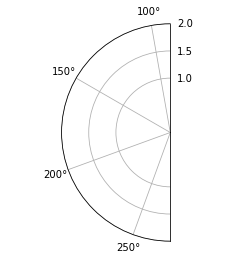

2021-01-11 14:48:35,588 __main__ 0/1 INFO :: Iteration: 19, Time: 1.900000e-02, dt: 1.000000e-03


KeyboardInterrupt: 

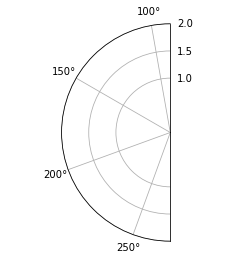

In [11]:
# Make plot of scalar field
r = domain.grid(1,scales=domain.dealias)
th = domain.grid(0,scales=domain.dealias)
thm, rm = np.meshgrid(th,r)
#fig, axis = plt.subplots(figsize=(10,5))
fig, axis = plt.subplots(subplot_kw={'projection': 'polar'})
p = axis.pcolormesh(thm+np.pi/2, rm, C['g'].T, cmap='RdBu_r');
#axis.plot(np.transpose(th), r)
axis.set_rmax(2)
axis.set_rticks([1, 1.5, 2])  # Less radial ticks
axis.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
axis.set_thetamin(90)
axis.set_thetamax(270)
axis.grid(True)
#axis.set_xlim([0,np.pi])
#axis.set_ylim([1,2])
slides = []

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    #dt = cfl.compute_dt()
    dt = 1e-3
    #print(dt)
    #time.sleep(5)
    solver.step(dt)
    #if solver.iteration % 10 == 0:
        # Update plot of scalar field
    p.set_array(np.ravel(C['g'][:-1,:-1].T))
    display.clear_output()
    display.display(plt.gcf())
    logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
        #slides.append(C['g'].T)
        #print(C['g'].T)
        #time.sleep(5)
end_time = time.time()
#with open ('Save.p', 'wb') as pfile :
    #pickle.dump(slides, pfile)

p.set_array(np.ravel(C['g'][:-1,:-1].T))
display.clear_output()
# Print statistics
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

## Analysis

As an example of doing some analysis, we will load in the horizontally averaged profiles of the scalar field $s$ and plot them.

In [ ]:
# Read in the data
f = h5py.File('analysis_tasks/analysis_tasks_s1/analysis_tasks_s1_p0.h5','r')
r = f['/scales/r/1.0'][:]
t = f['scales']['sim_time'][:]
C_ave = f['tasks']['C profile'][:]
f.close()

C_ave = C_ave[:,0,:] # remove length-one x dimension

In [ ]:
#N = len(S_ave[:,1])
for i in range(0,41,5):
  plt.plot(C_ave[i,:],r,label='t=%4.2f' %t[i])

plt.ylim([1,2])
plt.xlim([0,np.pi])
plt.xlabel(r'$\frac{2}{\pi}\int \ C d\theta$',fontsize=24)
plt.ylabel(r'$r$',fontsize=24)
plt.legend(loc='lower right').draw_frame(False)

In [ ]:
#with open ('Save.p', 'rb') as pfile :
#    slides = pickle.load(pfile)

In [ ]:
fig, axis = plt.subplots(subplot_kw={'projection': 'polar'})

for i in range(len(slides)):

    plt.imshow(slides[i])
    plt.pause(0.01) # pause avec duree en secondes

axis.set_rmax(2)
axis.set_rticks([1, 1.5, 2])  # Less radial ticks
axis.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
axis.set_thetamin(90)
axis.set_thetamax(270)
axis.grid(True)

In [ ]:
#with open ('Coord.p', 'wb') as pfile :
#    pickle.dump((thm, rm), pfile)